# Data Science Project - Predict Occupancy Rates using Boston and Seattle Airbnb Data

The Airbnb datasets are available on Kaggle to download:
Boston - https://www.kaggle.com/airbnb/boston
Seattle - https://www.kaggle.com/airbnb/seattle 

I am using these datasets to apply concepts learned in the Data Scientist Nanodegree program. I will follow the CRISP-DM process, and start with defining key business questions to be answered.

## Business Understanding
In this notebook, I am trying to answer the following questions:
1. What are the busiest times of the year in Seattle and Boston?

2. Do prices show any seasonality? Do prices spike during peak season?

3. Which are the key drivers of occupancy rates? Are these different for Boston and Seattle?

I am restricting the analysis to the above 3 questions but the datasets provide opportunity to frame and answer many other business questions like what are visitors/renters saying about their experience?, what are key drivers of price?, is there any advantage for hosts if they are tagged as 'superhost'? Depends on how curious you are and how much time you have available.

In [88]:
### Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

## Data Understanding and Data Wrangling

The next step in the CRISP-DM process is to understanding the data. Do we have necessary data to answer the business questions?
I framed the business questions going through the data and reviewing the basic definitions for each data supplied by Airbnb.

There are following 3 datasets available for each city:
1) Calendar: Daily availability and price for each listing id, covering 365 days.

2) Listings: Details about each listing, including average review score and full descriptions.

3) Reviews: Unique id for each reviewer and detailed comments.

Let me take a closer look at the data though to check the following:
•	Each column is a variable and each row is an individual
•	Size of the data - # of rows and columns
•	Missing values in rows or columns
•	Columns with a different data type than we would expect

For this analysis, I will focus on Calendar and Listings datasets.
The idea is to use 'Calendar' data to answer first two questions - busiest times of the year and price trends. I might also be able to extract occupany rates by listing id from this dataset if it is not already available in the Listings dataset.
I will use the Listings dataset to identify key drivers of occupancy rates.

Before doing any of that, let me read the datasets into the notebook and check the data size and first few rows of the data

In [120]:
## Datasets for Boston
Boston_calendar = pd.read_csv('https://raw.githubusercontent.com/ajayrao1983/Udacity---Data-Science-Project/main/Data/Boston/calendar.csv')
Boston_listings = pd.read_csv('https://raw.githubusercontent.com/ajayrao1983/Udacity---Data-Science-Project/main/Data/Boston/listings.csv') 

## Datasets for Seattle
Seattle_calendar = pd.read_csv('https://raw.githubusercontent.com/ajayrao1983/Udacity---Data-Science-Project/main/Data/Seattle/calendar.csv')
Seattle_listings = pd.read_csv('https://raw.githubusercontent.com/ajayrao1983/Udacity---Data-Science-Project/main/Data/Seattle/listings.csv')

In [121]:
# Shape of Boston_calendar data and print first 6 rows
print('Shape of Boston Calendar data: {}\n'.format(np.shape(Boston_calendar)))

print('First 6 rows of Boston Calendar data.')
print(Boston_calendar.head(6))

Shape of Boston Calendar data: (1308890, 4)

First 6 rows of Boston Calendar data.
   listing_id        date available price
0    12147973  2017-09-05         f   NaN
1    12147973  2017-09-04         f   NaN
2    12147973  2017-09-03         f   NaN
3    12147973  2017-09-02         f   NaN
4    12147973  2017-09-01         f   NaN
5    12147973  2017-08-31         f   NaN


In [4]:
# Shape of Seattle_calendar data and print first 6 rows
print('Shape of Seattle Calendar data: {}\n'.format(np.shape(Seattle_calendar)))

print('First 6 rows of Seattle Calendar data.')
print(Seattle_calendar.head(6))

Shape of Seattle Calendar data: (1393570, 4)

First 6 rows of Seattle Calendar data.
   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN



Calendar dataset for Boston has 1,308,890 rows and 4 columns while for Seattle has 1,393,570 rows and 4 columns. There are missing values in 'price' column when a listing is not available to rent which makes sense.

Given that both datasets have the same structure, it might be more efficient for me to combine them first and then work on cleaning the combined data. That way I will only have to do it once.

Before combining the data, I will add a 'city' column to differentiate data at a later stage if required. It will also help avoid corrupting that data if listing ids are common across the two datasets.
Once combined, I will delete the individual city datasets.

listing_id and date columns are intuitive. 
'available' column is either 'f' if the listing is unavailable for given date or 't' if the listing is available for given date. 'price' column is given if the listing is available i.e. if the 'available' column is 't' or it is NaN

In [5]:
# Create a 'city' column
Boston_calendar['city'] = 'Boston'
Seattle_calendar['city'] = 'Seattle'

# Append the two datasets to create a Total_calendar data
Total_calendar = pd.concat([Boston_calendar, Seattle_calendar])
del Boston_calendar, Seattle_calendar #Delete Boston and Seattle calendar data

Total_calendar.head(6)

,listing_id,date,available,price,city
0,12147973,2017-09-05,f,NaN,Boston
1,12147973,2017-09-04,f,NaN,Boston
2,12147973,2017-09-03,f,NaN,Boston
3,12147973,2017-09-02,f,NaN,Boston
4,12147973,2017-09-01,f,NaN,Boston
5,12147973,2017-08-31,f,NaN,Boston


I will check for missing columns in the combined dataset, and validate the assumption that 'price' column is only missing if the listing is unavailable

In [6]:
## Check missing values when a listing is available
print('Missing values when the listing is available')
print(Total_calendar[Total_calendar['available'] == 't'].isnull().mean())

## Check missing values when a listing is not available
print('\nMissing values when the listing is unavailable')
print(Total_calendar[Total_calendar['available'] == 'f'].isnull().mean())

Missing values when the listing is available
listing_id    0.0
date          0.0
available     0.0
price         0.0
city          0.0
dtype: float64

Missing values when the listing is unavailable
listing_id    0.0
date          0.0
available     0.0
price         1.0
city          0.0
dtype: float64


This confirms my assumption about the 'price' column. Before proceeding further, let me check if the columns are of the right type.

In [7]:
## check the column types
print(Total_calendar.dtypes)

listing_id     int64
date          object
available     object
price         object
city          object
dtype: object


Some columns have a different data type than what I expected. There is no point keeping Listing ID as numeric because I won't be running any mathematical operation on this column like sum, average etc.
On the other hand, I will need the date column to be of date or datetime type and price to be of numeric type so I can run appropriate operations on these columns like plot a time series using the date column or get average price for a given date or listing id.

Let me change the data types before going any further. After running the transformations, I will validate if the data types have been changed correctly and no missing values are introduced.

In [8]:
Total_calendar['listing_id'] = Total_calendar['listing_id'].astype(str) # Change 'listing_id' to string
Total_calendar['price'] = Total_calendar['price'].str.replace('$','').str.replace(',','').astype(float) # Change 'price' to float
Total_calendar['date'] = pd.to_datetime(Total_calendar['date']) # Change date to 'date'

# Validate if the type transformations has not introduced new missing values
print('Missing values when the listing is available')
print(Total_calendar[Total_calendar['available'] == 't'].isnull().mean())

print('\nMissing values when the listing is unavailable')
print(Total_calendar[Total_calendar['available'] == 'f'].isnull().mean())

print('\n')
print(Total_calendar.dtypes)

C:\Users\ajay_\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


Missing values when the listing is available
listing_id    0.0
date          0.0
available     0.0
price         0.0
city          0.0
dtype: float64

Missing values when the listing is unavailable
listing_id    0.0
date          0.0
available     0.0
price         1.0
city          0.0
dtype: float64


listing_id            object
date          datetime64[ns]
available             object
price                float64
city                  object
dtype: object


Now that the data types are corrected, let us look at price variable in more detail.

In [9]:
# Get basic stats on 'price' grouped by 'city'
Total_calendar.groupby('city').describe()

price                                                          
            count        mean         std   min   25%    50%    75%     max
city                                                                       
Boston   643037.0  198.438909  180.142913  11.0  85.0  150.0  255.0  7163.0
Seattle  934542.0  137.944859  105.062870  10.0  75.0  109.0  160.0  1650.0

The mean is greater than median across both cities. This indicates that price is skewed to the right and has a wide range for both cities, more so for Boston. Boston is more expensive than Seattle.

If we are looking at price trend, median might make more sense rather than mean.

In [11]:
## Create trendata by summarizing data by 'date' and 'city'
# count of 'price' gives number of available listings as price will be missing if a listing is not available
trenddata = Total_calendar.groupby(['date','city'], as_index=False).agg({'price': ['mean', 'median', 'count'],
                                                 'listing_id': 'nunique'})


trenddata.columns = ['date', 'city', 'avg_price', 'median_price', 'available_listings', 'total_listings'] #Rename columns
trenddata['occupied_listings'] = trenddata['total_listings'] - trenddata['available_listings'] #Calculate occupied listings

# Compute occupancy rate as (Occupied Listings / Total Listings)
trenddata['dailyoccrate'] = round((trenddata['occupied_listings'] / trenddata['total_listings']) * 100, 1)
# Round of average price to 2 digits after decimal to make it easier to read
trenddata['avg_price'] = round(trenddata['avg_price'], 2) 

print('First 5 rows of the data')
print(trenddata.head())
print('\nFirst 5 rows of data where city is Boston')
print(trenddata[trenddata['city'] == 'Boston'].head())

First 5 rows of the data
        date     city  avg_price  median_price  available_listings  \
0 2016-01-04  Seattle     122.09          99.0                1735   
1 2016-01-05  Seattle     120.68          99.0                1867   
2 2016-01-06  Seattle     120.93          99.0                1826   
3 2016-01-07  Seattle     120.96          99.0                1776   
4 2016-01-08  Seattle     127.64         100.0                1782   

   total_listings  occupied_listings  dailyoccrate  
0            3818               2083          54.6  
1            3818               1951          51.1  
2            3818               1992          52.2  
3            3818               2042          53.5  
4            3818               2036          53.3  

First 5 rows of data where city is Boston
          date    city  avg_price  median_price  available_listings  \
246 2016-09-06  Boston     241.04         192.0                 570   
248 2016-09-07  Boston     251.83         210.0    

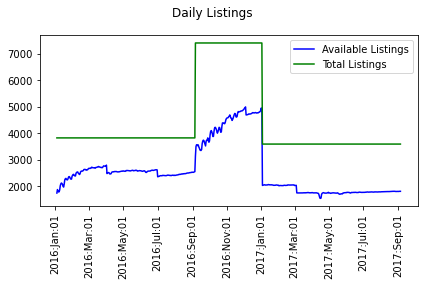

In [110]:
## Plotting total (Boston + Seattle) trends of Total Listings and Available Listings 

# Create a combined data by grouping the trendata by date only
temp_plot = trenddata.groupby(['date'], as_index = False).agg({'available_listings': 'sum',
                                                              'total_listings': 'sum'})

# Rename columns
temp_plot.columns = ['Date', 'Available', 'Total']

## Generate a line plot for Total and Available listings
fig, ax = plt.subplots()

fig.suptitle('Daily Listings') ## Title of the plot

ax.plot_date(temp_plot.Date, temp_plot.Available, 'b', label='Available Listings')
ax.plot_date(temp_plot.Date, temp_plot.Total, 'g', label = 'Total Listings')
ax.xaxis.set_major_formatter(DateFormatter('%Y:%b:%d')) # Use date format for X-axis
ax.legend()

plt.xticks(rotation=90) # Rotate x axis labels by 90 degrees
fig.tight_layout()

plt.show()

##### Observation:
Total listings almost double in the months of Sep to Dec in 2016, falling back in Jan. Available listings also shoot up in September, but then grow gradually peaking in Dec.
The trends looks very odd and warrants further analysis. Maybe plotting the data by cities might throw some light.

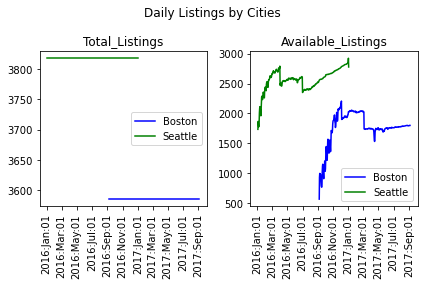

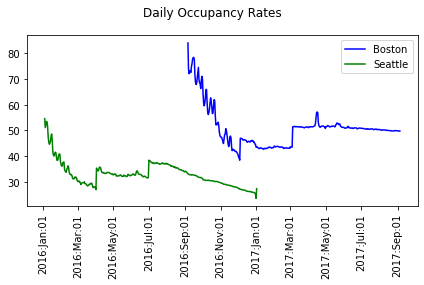

In [111]:
## Separate data by cities for plotting
Boston_plot = trenddata[trenddata['city'] == 'Boston']
Seattle_plot = trenddata[trenddata['city'] == 'Seattle']


## Create separate Total and Available listings plots for Boston and Seattle
fig, ax = plt.subplots(1,2)

fig.suptitle('Daily Listings by Cities')

ax[0].set_title('Total_Listings')
ax[0].plot_date(Boston_plot.date, Boston_plot.total_listings, 'b', label='Boston')
ax[0].plot_date(Seattle_plot.date, Seattle_plot.total_listings, 'g', label = 'Seattle')
ax[0].xaxis.set_major_formatter(DateFormatter('%Y:%b:%d'))
ax[0].tick_params('x', labelrotation = 90)
ax[0].legend()

ax[1].set_title('Available_Listings')
ax[1].plot_date(Boston_plot.date, Boston_plot.available_listings, 'b', label='Boston')
ax[1].plot_date(Seattle_plot.date, Seattle_plot.available_listings, 'g', label = 'Seattle')
ax[1].xaxis.set_major_formatter(DateFormatter('%Y:%b:%d'))
ax[1].tick_params('x', labelrotation = 90)
ax[1].legend()

fig.tight_layout()

plt.show()

## Create a daily occupancy rate plot for Boston and Seattle
fig, ax = plt.subplots()

fig.suptitle('Daily Occupancy Rates')

ax.plot_date(Boston_plot.date, Boston_plot.dailyoccrate, 'b', label = 'Boston')
ax.plot_date(Seattle_plot.date, Seattle_plot.dailyoccrate, 'g', label = 'Seattle')
ax.xaxis.set_major_formatter(DateFormatter("%Y:%b:%d"))
ax.tick_params('x', labelrotation = 90)
ax.legend()

fig.tight_layout()

plt.show()

##### Observation:
Plotting the trends by cities shows data for Boston and Seattle are set in different time frames with data overlapping in Sep to Dec 2016. That clarifies why the listings doubled in those months.

The trends for available listings for Boston and Seattle in the first 6 months are pretty similar: rapid growth in the first 3 months, flattening out in the next 3 and then dipping in the 7th month. Available listing for Seattle continues to grow from Jul 2016 to Dec 2016. On the other hand, available listings for Boston remain flat from Mar to Sep 2017.

***Answer to Question 1 - Busiest times of the year***
If we discredit the first 3 months for each city trend, the occupancy rates seem to peak in the summer (Jul to Sep) in Seattle and Spring (Mar to Jul) in Boston. We could be more sure about seasonality if the data was two or more years for each city. 

To answer the next question, I will need to plot price trends. I already have daily average and median prices in the 'trenddata'

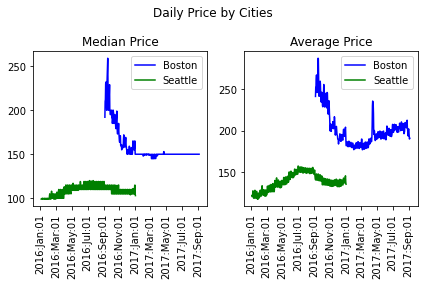

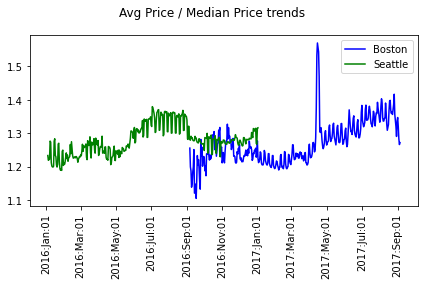

In [112]:
## Using the Boston_plot and Seattle_plot datasets created in the previous for plotting price trends


## Plot daily median and average prices for Boston and Seattle
fig, ax = plt.subplots(1,2)

fig.suptitle('Daily Price by Cities')

ax[0].set_title('Median Price')
ax[0].plot_date(Boston_plot.date, Boston_plot.median_price, 'b', label='Boston')
ax[0].plot_date(Seattle_plot.date, Seattle_plot.median_price, 'g', label = 'Seattle')
ax[0].xaxis.set_major_formatter(DateFormatter('%Y:%b:%d'))
ax[0].tick_params('x', labelrotation = 90)
ax[0].legend()

ax[1].set_title('Average Price')
ax[1].plot_date(Boston_plot.date, Boston_plot.avg_price, 'b', label='Boston')
ax[1].plot_date(Seattle_plot.date, Seattle_plot.avg_price, 'g', label = 'Seattle')
ax[1].xaxis.set_major_formatter(DateFormatter('%Y:%b:%d'))
ax[1].tick_params('x', labelrotation = 90)
ax[1].legend()

fig.tight_layout()

plt.show()

## Plot ratio of average price to median price for Boston and Seattle

fig, ax = plt.subplots()

fig.suptitle('Avg Price / Median Price trends')

ax.plot_date(Boston_plot.date, Boston_plot.avg_price / Boston_plot.median_price, 'b', label = 'Boston')
ax.plot_date(Seattle_plot.date, Seattle_plot.avg_price / Seattle_plot.median_price, 'g', label = 'Seattle')
ax.xaxis.set_major_formatter(DateFormatter("%Y:%b:%d"))
ax.tick_params('x', labelrotation = 90)
ax.legend()

fig.tight_layout()

plt.show()

##### Observation:

The plots for average prices peak during summer (May to Sep) in Boston and Seattle. This is the period when the average price is particularly higher than the median price (refer the 2nd plot above of Average Price over Median Price), hinting at more expensive listings becoming available at this time. 

***Answer to Question2 - does price show any seasonality and does it peak during busy season?*** 
I would conclude that prices are seasonal, peaking in summer.
The high prices in Boston from Sep to Dec might be because only expensive listings might be available at this time skewing the data.


Moving on to the last question, I will first compute the occupancy rate for each listing using the calendar dataset.
Then, I will focus on the listing dataset. Similar to the calendar datasets, I will start with getting basic details about the listings dataset like shape of the data and first 5 rows of data.

In [34]:
## Creating a boolean column that is 1 if 'available' column is 'f', 0 otherwise to compute occupancy rates

Total_calendar['unavail_bool'] = np.where(Total_calendar['available'] == 'f', 1, 0)

Total_calendar.head()

,listing_id,date,available,price,city,unavail_bool
0,12147973,2017-09-05,f,NaN,Boston,1
1,12147973,2017-09-04,f,NaN,Boston,1
2,12147973,2017-09-03,f,NaN,Boston,1
3,12147973,2017-09-02,f,NaN,Boston,1
4,12147973,2017-09-01,f,NaN,Boston,1


In [41]:
## Creating a dataframe of occupancy rate by Listing ID and City

# Count of date gets total entries (expected to be 365) and 
# sum of the boolean column we created in the step above gives total days the listing was unavailable or occupied
Listing_occrate = Total_calendar.groupby(['city','listing_id'], as_index=False).agg({'date': 'count',
                                                             'unavail_bool': 'sum'})

# Occupancy rate is calculated as (Days Occupied / Total Days)
Listing_occrate['occrate'] = round((Listing_occrate['unavail_bool'] / Listing_occrate['date']) * 100, 1)

# Keep Listing ID, City and Occupancy Rate columns
Listing_occrate.drop(['date', 'unavail_bool'], axis = 1, inplace = True)

Listing_occrate.head()

,city,listing_id,occrate
0,Boston,10004575,75.3
1,Boston,10009367,100.0
2,Boston,10021398,10.1
3,Boston,10032327,79.5
4,Boston,10033322,51.0


In [13]:
## checking Listings datasets for Boston and Seattle

print('Shape of Boston Listings data: {}\n'.format(np.shape(Boston_listings)))

print('First 6 rows of Boston Listings data.')
print(Boston_listings.head(6))

print('Shape of Seattle Listings data: {}\n'.format(np.shape(Seattle_listings)))

print('First 6 rows of Seattle Listings data.')
print(Seattle_listings.head())

Shape of Boston Listings data: (3585, 95)

First 6 rows of Boston Listings data.
         id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   
5  12386020  https://www.airbnb.com/rooms/12386020  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   
5   2016-09-07                 Private

##### Observation:
The Boston Listings dataset has 3,585 rows and 95 columns. The Seattle Listings dataset has 3,818 rows and 92 columns. It would be interesting to see which 3 columns are absent in the Seattle Listings dataset.

In [19]:
set(Boston_listings.columns).difference(set(Seattle_listings.columns))

{'access', 'house_rules', 'interaction'}

*'access', 'house_rules' and 'interaction'* are absent in the Boston Listings dataset. I will exclude these from the analysis to keep it consistent across Boston and Seattle.

Using the Calendar dataset I will compute the occupancy rate by Listing ID and City. Then, I will pull some explanatory variables from the Listings dataset to help predict the occupancy rates using the 'id' column as key. However, there are too many columns to work with and most of them don't seem to be useable or look like they wouldn't add value to the analysis.

So I will select a subset of the columns to keep for modeling.

In [21]:
Seattle_listings.columns ## List all columns in the Seattle dataset since it has the 3 additional columns missing in Boston dataset

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [117]:
print(Seattle_listings['city'].unique())

['Seattle' 'Ballard, Seattle' 'West Seattle' 'Seattle ' '西雅图'
 'Phinney Ridge Seattle' 'seattle']


I will need 'id' and 'city' to merge datasets. The existing 'city' column has multiple city entries, some in a foreign language. I will drop the existing 'city' column and replace with a new 'city' column to differentiate 'Boston' data vs 'Seattle'.

From the rest, I feel the following columns would influence the occupancy rates for a given listing:
'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication','review_scores_location', 'review_scores_value', 'requires_license','instant_bookable','cancellation_policy', 'require_guest_profile_picture',
'require_guest_phone_verification', 'calculated_host_listings_count' and 'reviews_per_month'

I will create a list of these columns and then create a Total Listings data by appending the Listings data for Boston and Seattle. Similar to the calendar data, I will process the data on the combined data to avoid duplication of efforts.

In [79]:
## Create a list of columns to keep
myvars = ['id', 'city', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
          'host_identity_verified', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 
          'bedrooms', 'beds', 'bed_type', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 
          'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 
          'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 
          'review_scores_communication','review_scores_location', 'review_scores_value', 'requires_license',
          'instant_bookable','cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 
          'calculated_host_listings_count', 'reviews_per_month' ]

## Drop the existing city column
Boston_listings.drop(['city'], axis = 1, inplace = True)
Seattle_listings.drop(['city'], axis = 1, inplace = True)

## Create a new city column
Boston_listings['city'] = 'Boston'
Seattle_listings['city'] = 'Seattle'

## Append the Boston and Seattle datasets
Total_listings = pd.concat([Boston_listings[myvars],
                           Seattle_listings[myvars]])

del myvars ## Delete list of variables since it is not used in rest of the analysis

Total_listings.groupby(['city']).describe()

id                                                             \
          count          mean           std     min         25%        50%   
city                                                                         
Boston   3585.0  8.440875e+06  4.500787e+06  3353.0  4679319.00  8577620.0   
Seattle  3818.0  5.550111e+06  2.962660e+06  3335.0  3258256.25  6118244.5   

                                 accommodates            ...  \
                 75%         max        count      mean  ...   
city                                                     ...   
Boston   12789527.00  14933461.0       3585.0  3.041283  ...   
Seattle   8035126.75  10340165.0       3818.0  3.349398  ...   

        calculated_host_listings_count        reviews_per_month            \
                                   75%    max             count      mean   
city                                                                        
Boston                             6.0  136.0            2829.0  1.970908   
Seattle                            2.0   37.0            3191.0  2.078919   

                                                   
              std   min    25%   50%   75%    max  
city                                               
Boston   2.120561  0.01  0.480  1.17  2.72  19.15  
Seattle  1.822348  0.02  0.695  1.54  3.00  12.15  

[2 rows x 152 columns]

Couldn't get anything meaningful out of the table.

A summary data frame which lists each column, the column type, and number of missing values split by Boston and Seattle might be more insightful.

In [33]:
## Create the summary data frame

## First get list of % missing values for Boston city
Listings_summarydf = pd.Series.to_frame(Total_listings[Total_listings['city']=='Boston'].isnull().mean().sort_values(ascending = False))

## Merge with % missing values for Seattle by column names
Listings_summarydf = Listings_summarydf.merge(pd.Series.to_frame(Total_listings[Total_listings['city']=='Seattle'].isnull().mean().sort_values(ascending = False)),
                         left_index = True, right_index = True)

## Merge column types to existing data frame by column names
Listings_summarydf = Listings_summarydf.merge(pd.Series.to_frame(Total_listings.dtypes),
                                              left_index = True, right_index = True)

## Give meaningful names to the columns
Listings_summarydf.columns = ['Boston', 'Seattle', 'Data_type']

## Reset index of the newly created dataframe so the variable names get transformed into a separate column
Listings_summarydf.reset_index(inplace=True)

## Name the variable column
Listings_summarydf.rename(columns = {'index': 'vars'}, inplace = True)

Listings_summarydf

,vars,Boston,Seattle,Data_type
0,square_feet,0.984379,0.974594,float64
1,monthly_price,0.752301,0.602672,object
2,weekly_price,0.751185,0.473808,object
3,security_deposit,0.625662,0.511262,object
4,cleaning_fee,0.308787,0.269775,object
5,review_scores_accuracy,0.229568,0.172342,float64
6,review_scores_location,0.229289,0.171556,float64
7,review_scores_value,0.229010,0.171818,float64
8,review_scores_checkin,0.228731,0.172342,float64
9,review_scores_communication,0.228173,0.170508,float64


##### Observations

1) The 'square_feet' column is mostly empty for both cities. No point keeping it in the model.

2) 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee' are of type 'string'. This could be due to the '$' and ','. These need to be coverted to numeric or float.

3) 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee have missing values. The missing values can be treated as if they are not relevant for the listing id. For example, if a listing doesn't have 'weekly_price' it means the listing doesn't allow the property to be booked for a week. These columns can be converted into a boolean

4) 'host_is_superhost' and 'host_identity_verified' have some missing values in the Seattle dataset. I will consider the missing values as 'f'

5) Missing values for 'bathrooms', 'bedrooms' and 'beds' will be replaced with 0

6) Missing values for 'reviews_per_month' will be replaced with 0, i.e. there are no reviews for given listing

7) Missing values for review scores will be replaced with a default value of 1 or minimum rating

8) Listing ID is stored as numeric. Will convert this to string

9) 'host_response_rate' and 'host_acceptance_rate' are stored as string because of "\%" need to convert these to number. Missing values in these columns will be replaced with 0s

In [80]:
## Convert column types

# 'id' to string
Total_listings['id'] = Total_listings['id'].astype(str)

# 'price' and charges for 'extra_people' to float
Total_listings['price'] = Total_listings['price'].str.replace('$','').str.replace(',','').astype(float)
Total_listings['extra_people'] = Total_listings['extra_people'].str.replace('$','').str.replace(',','').astype(float)

# 'host_response_rate' and 'host_acceptance_rate' to float
Total_listings['host_response_rate'] = Total_listings['host_response_rate'].str.replace('%','').astype(float)
Total_listings['host_acceptance_rate'] = Total_listings['host_acceptance_rate'].str.replace('%','').astype(float)

C:\Users\ajay_\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
C:\Users\ajay_\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


In [81]:
## Convert columns 'host_is_superhost', 'host_identity_verified','is_location_exact', 'instant_bookable', 
## 'require_guest_profile_picture','require_guest_phone_verification',
## 'monthly_price', 'weekly_price', 'security_deposit' and 'cleaning_fee' to boolean

for i in ['host_is_superhost', 'host_identity_verified','is_location_exact', 'instant_bookable', 
       'require_guest_profile_picture','require_guest_phone_verification']:
    Total_listings[i] = np.where(Total_listings[i] == 't', 1, 0)

for i in ['monthly_price', 'weekly_price', 'security_deposit', 'cleaning_fee']:
    Total_listings[i] = np.where(Total_listings[i].notnull(), 1, 0)
    
del i

In [82]:
## fill missing values in 'reviews_per_month', 'beds', 'bathrooms', 'bedrooms', 'host_response_rate' and 'host_acceptance_rate'
## columns with 0s
for i in ['reviews_per_month', 'beds', 'bathrooms', 'bedrooms', 'host_response_rate', 'host_acceptance_rate']:
    Total_listings[i].fillna(value = 0, inplace = True)

del i

## fill missing values in 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','
## review_scores_checkin','review_scores_communication','review_scores_location' and 'review_scores_value' 
## columns with minimum value in that column

for i in ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 
          'review_scores_communication','review_scores_location', 'review_scores_value']:    
    Total_listings[i].fillna(Total_listings[i].min(), inplace = True)
    
del i

In the steps above, I have converted column types and addressed the missing values in numeric columns. I have also addressed missing values in some categorical column by converting them to boolean and replacing missing values with 0s.

Before building the models however, I still have to convert categorical columns into dummies. That should in turn take care of missing values too. Before I start working on categorical columns, let me pull in the occupancy rates and drop the columns that are not required for modeling

In [91]:
## Merge data with occupancy rate by listings with Total Listing data frame
## To create model_df that we eventually use to build the model

model_df = Listing_occrate.merge(Total_listings, left_on = ['city', 'listing_id'], right_on = ['city', 'id'],
                                how = 'outer')

## Drop 'listing_id' and 'id' as these are relevant for building the model
model_df.drop(['listing_id', 'id', 'square_feet'], axis = 1, inplace = True)

model_df.isnull().mean()

city                                0.00000
occrate                             0.00000
host_response_time                  0.13427
host_response_rate                  0.00000
host_acceptance_rate                0.00000
host_is_superhost                   0.00000
host_identity_verified              0.00000
is_location_exact                   0.00000
property_type                       0.00054
room_type                           0.00000
accommodates                        0.00000
bathrooms                           0.00000
bedrooms                            0.00000
beds                                0.00000
bed_type                            0.00000
price                               0.00000
weekly_price                        0.00000
monthly_price                       0.00000
security_deposit                    0.00000
cleaning_fee                        0.00000
guests_included                     0.00000
extra_people                        0.00000
minimum_nights                  

In [63]:
## Define a function that generates dummies for categorical variables
## While keeping numeric variables intact

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [92]:
## Extract categorical columns of model_df as list to pass to 'create_dummy_df' function
catcols = list(model_df.select_dtypes(include = 'object').columns)

## Pass dataframe and categorical column list to the function and store the returned data frame as model_df
model_df = create_dummy_df(model_df, catcols, dummy_na = False)

model_df

,occrate,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,...,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
0,75.3,100.0,100.0,0,1,1,6,1.0,3.0,5.0,...,0,0,0,0,0,0,1,0,1,0
1,100.0,90.0,91.0,1,1,1,2,1.0,2.0,1.0,...,0,0,0,0,0,0,1,0,1,0
2,10.1,90.0,95.0,0,0,0,2,1.0,1.0,1.0,...,0,1,0,0,0,0,1,0,0,0
3,79.5,100.0,67.0,1,1,1,4,1.0,1.0,2.0,...,0,0,0,0,0,0,1,0,1,0
4,51.0,98.0,55.0,0,1,1,3,1.0,1.0,1.0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7398,0.0,96.0,100.0,0,1,1,6,2.0,2.0,2.0,...,0,0,0,0,0,0,1,0,1,0
7399,77.5,100.0,100.0,0,1,1,2,1.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,0
7400,1.4,100.0,100.0,0,0,1,2,1.0,0.0,2.0,...,0,0,0,0,0,0,1,0,1,0
7401,83.3,100.0,0.0,0,0,1,6,3.0,5.0,5.0,...,0,0,0,0,0,0,1,1,0,0


In [86]:
## Define a function to fit the model and predit scores for train and test dataset

def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    '''
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [93]:
#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(model_df, 'occrate')

In [94]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.1863765420669008.  The rsquared on the test data was 0.17077443805008663.


##### Observation:

The R-Square of the model is low but the scores for test and train dataset is pretty close suggesting that the model is not overfitting the training data.

To identify the top drivers of occupancy rate within the data that we have, I will extract the coefficients and sort them in descending order. The data is normalize while fitting the models that enables me to compare the coefficients across the variables.

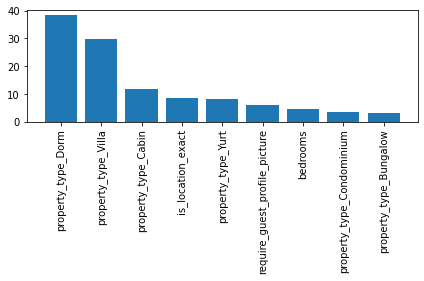

In [109]:
## Data Frame with variable scores
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(lm_model.coef_))], axis = 1)

## Giving meaningful names to the columns
coefficients.columns = ['Variables', 'Coeffs']
# Sort the data frame in descending order of scores
coefficients.sort_values(by = 'Coeffs', ascending = False, inplace = True)

## Create a bar plot for top 10 drivers
fig, ax = plt.subplots()

ax.bar(coefficients.Variables[0:9], coefficients.Coeffs[0:9])
ax.tick_params('x', rotation = 90)    


fig.tight_layout()
    
plt.show()


***Answer to Question 3 - Key drivers of Occupancy Rate***

Property type comes out as the most important feature. Dorm and Villa seem to be very popular with guests.
Location accuracy is also important for the guests, followed by whether the listing requires a profile picture. This might be related to feeling of security as it has a positive coefficient.

You are free to build other models or upgrade the model by adding other dataset like guest reviews or any other dataset.